# EDA

**Imports**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import qgrid  # Convenient way to explore data frames interactively.
import seaborn as sns

style.use("fivethirtyeight")

## Reading in the data, checking for nulls or unexpected data types.

In [2]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [3]:
# I explored the data trying to get a sense of what was there.
# I noticed the wide range of values for the different attributes as well as the sparsity.

grid = qgrid.QGridWidget(df=df, show_toolbar=True)
grid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
df.tail()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
124489,15306,Z1F0MA1S,18310224,0,0,0,10,353705,8,8,0,0
124490,15306,Z1F0Q8RT,172556680,96,107,4,11,332792,0,0,13,0
124491,15306,Z1F0QK05,19029120,4832,0,0,11,350410,0,0,0,0
124492,15306,Z1F0QL3N,226953408,0,0,0,12,358980,0,0,0,0
124493,15306,Z1F0QLC1,17572840,0,0,0,10,351431,0,0,0,0


Checking for null values

In [5]:
df.isnull().sum()

date          0
device        0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
failure       0
dtype: int64

In [6]:
# Make sure all the devices are actually there and not empty strings
df['device'].sort_values(ascending=False)

45203    Z1F2PBHX
43187    Z1F2PBHX
54650    Z1F2PBHX
28591    Z1F2PBHX
30726    Z1F2PBHX
           ...   
2326     S1F01085
4651     S1F01085
5812     S1F01085
3489     S1F01085
0        S1F01085
Name: device, Length: 124494, dtype: object

In [7]:
df.shape

(124494, 12)

In [8]:
# Making sure each column is the expected type.

df.dtypes

date           int64
device        object
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
failure        int64
dtype: object

## Looking at the two classes
Baseline accuracy $= 0.999$ 

In [9]:
# There didn't seem to be very many of the positive ("failed") class when inspecting the data frame.
# The classes are heavily imbalanced and I will need to take special care when modeling.

df['failure'].value_counts(normalize=True)

0    0.999149
1    0.000851
Name: failure, dtype: float64

In [10]:
# Checking the number of devices and how often they appear.

df['device'].value_counts()

S1F0FP0C    304
Z1F0GE1M    304
W1F0FY92    304
S1F0GCED    304
S1F0E9EP    304
           ... 
W1F0YKBQ      5
Z1F161QC      5
S1F0A1VP      5
S1F04KSC      4
W1F0WJFT      3
Name: device, Length: 1168, dtype: int64

`failed_devices` is a list of all the devices that failed.  Failed devices had telemetry data until the day they did 
fail while not-failed devices (unsurprisingly) continued transmitting telemetry data.  I can use this list to filter 
the data frame to look specifically at devices that failed or devices that didn't fail, removing all of the data of 
failed devices.  I can better compare the differences in telemetry data and figure out which attributes are relevant.

In [11]:
failed_devices = list(df.query("failure == 1")['device'])
failed_devices[:20]

['S1F0RRB1',
 'S1F0CTDN',
 'W1F0PNA5',
 'W1F13SRV',
 'W1F1230J',
 'W1F0T034',
 'S1F0GG8X',
 'S1F023H2',
 'S1F0QY11',
 'S1F0S2WJ',
 'W1F0Z1W9',
 'W1F15S4D',
 'Z1F0LVPW',
 'Z1F0NVZA',
 'Z1F1FCH5',
 'S1F0P3G2',
 'W1F0F6BN',
 'W1F0P114',
 'W1F0X4FC',
 'S1F0LCTV']

## Separating the failed devices into a separate data frame for easier viewing.

This helps focus only on the devices that failed and how their attributes changed until they failed.

In [12]:
failed_df = df[df['device'].isin(failed_devices)]
failed_df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
7,15001,S1F023H2,141503600,0,0,1,19,494462,16,16,3,0
23,15001,S1F03YZM,55587136,0,0,0,7,199132,0,0,0,0
44,15001,S1F09DZQ,12568128,136,0,2,6,380112,0,0,2,0
63,15001,S1F0CTDN,50147888,528,0,4,9,381198,32,32,3,0
74,15001,S1F0DSTY,8471680,0,0,0,11,436682,0,0,0,0


In [13]:
failed_df.reset_index(inplace=True)

## Looking more closely at telemetry data.

This is to see if there are any insights on attributes with some simple aggregation.  Ideally this would help give better context to each attribute and if any of them stand out as features.

In [14]:
df.aggregate(np.mean)

date          1.510622e+04
attribute1    1.223868e+08
attribute2    1.594848e+02
attribute3    9.940455e+00
attribute4    1.741120e+00
attribute5    1.422269e+01
attribute6    2.601729e+05
attribute7    2.925282e-01
attribute8    2.925282e-01
attribute9    1.245152e+01
failure       8.514467e-04
dtype: float64

In [15]:
df.query('failure == 1').aggregate(np.mean)

date          1.510791e+04
attribute1    1.271755e+08
attribute2    4.109434e+03
attribute3    3.905660e+00
attribute4    5.463208e+01
attribute5    1.546226e+01
attribute6    2.583035e+05
attribute7    3.062264e+01
attribute8    3.062264e+01
attribute9    2.308491e+01
failure       1.000000e+00
dtype: float64

In [16]:
df.query('failure==0').aggregate(np.mean)

date          1.510622e+04
attribute1    1.223827e+08
attribute2    1.561187e+02
attribute3    9.945598e+00
attribute4    1.696048e+00
attribute5    1.422164e+01
attribute6    2.601745e+05
attribute7    2.666817e-01
attribute8    2.666817e-01
attribute9    1.244246e+01
failure       0.000000e+00
dtype: float64

## Plotting some of the attributes for 2 devices

In [17]:
# Preparing data from two devices to plot some of the attributes.

device = df.query('device == "Z1F2PBHX"')
device2 = df.query("device == 'Z1F0KKN4'")
x = device['date']

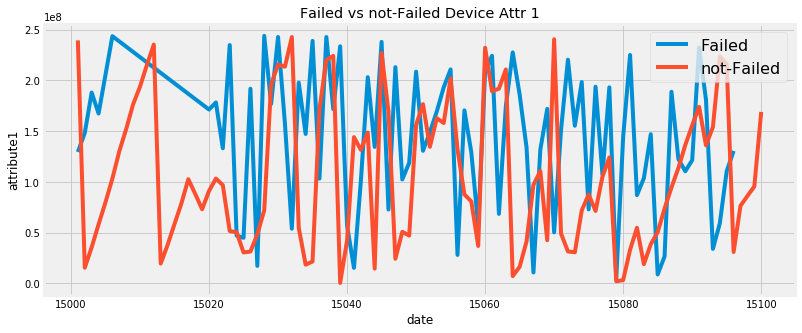

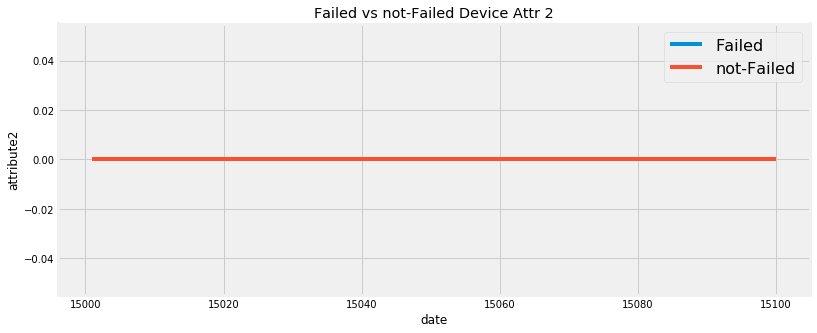

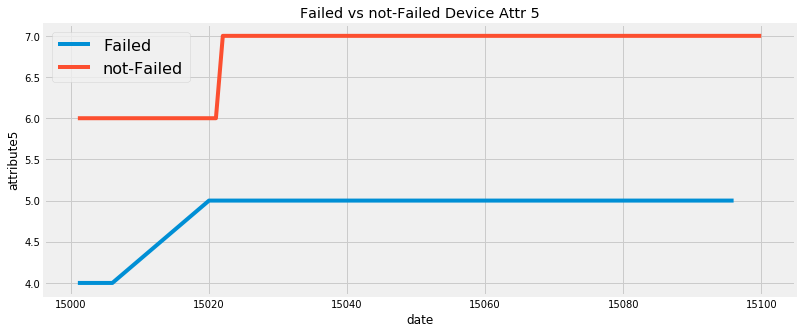

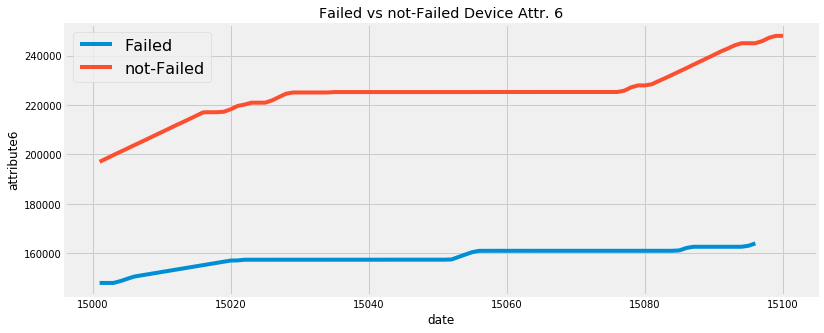

In [18]:
# Attribute 1
plt.figure(figsize=(12, 5))
sns.lineplot(x=x, y=device['attribute1'])
sns.lineplot(x=device2['date'][:100], y=device2['attribute1'])
plt.title("Failed vs not-Failed Device Attr 1")
plt.legend(("Failed", "not-Failed"), fontsize=16)

# Attribute 2
plt.figure(figsize=(12, 5))
sns.lineplot(x=x, y=device['attribute2'])
sns.lineplot(x=device2['date'][:100], y=device2['attribute2'])
plt.title("Failed vs not-Failed Device Attr 2")
plt.legend(("Failed", "not-Failed"), fontsize=16)

# Attribute 5
plt.figure(figsize=(12, 5))
sns.lineplot(x=x, y=device['attribute5'])
sns.lineplot(x=device2['date'][:100], y=device2['attribute5'])
plt.title("Failed vs not-Failed Device Attr 5")
plt.legend(("Failed", "not-Failed"), fontsize=16)

# Attribute 6
plt.figure(figsize=(12, 5))
sns.lineplot(x=x, y=device['attribute6'])
sns.lineplot(x=device2['date'][:100], y=device2['attribute6'])
plt.title("Failed vs not-Failed Device Attr. 6")
plt.legend(("Failed", "not-Failed"), fontsize=16)

Some attributes vary wildly in order of magnitude, such as `attribute2`, but didn't show much change when I plotted them.  The arithmetic mean likely isn't the best aggregation.  There is a time element to the data so a moving average might be more appropriate.  Even though these are only two devices, it's hard to infer any meaning from the attributes just by looking at them.

### Taking a look at separate devices and how they change 

In [19]:
df.sort_values(by='date', inplace=True)

In [20]:
df.query("device == 'S1F0RRB1'")

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
235,15001,S1F0RRB1,5230888,2288,0,37,8,39267,24,24,1,0
1398,15002,S1F0RRB1,13307628,64776,0,49,8,39267,56,56,1,0
2561,15003,S1F0RRB1,26258330,64776,0,135,8,39267,56,56,1,0
3724,15004,S1F0RRB1,37985862,64776,0,763,8,39267,56,56,1,0
4885,15005,S1F0RRB1,48467332,64776,0,841,8,39267,56,56,1,1


In [21]:
df.query("device == 'W1F0F6BN'").head(10)

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
557,15001,W1F0F6BN,113361680,0,0,0,12,225194,0,0,0,0
1720,15002,W1F0F6BN,132121976,0,0,0,12,226495,0,0,0,0
2883,15003,W1F0F6BN,153745136,0,0,0,12,227728,0,0,0,0
4046,15004,W1F0F6BN,176403712,0,0,0,12,228862,0,0,0,0
5207,15005,W1F0F6BN,200875200,0,0,0,12,230151,0,0,0,0
6321,15006,W1F0F6BN,221711128,0,0,0,12,231468,0,0,0,0
7245,15007,W1F0F6BN,1509976,0,0,0,12,232777,0,0,0,0
8009,15008,W1F0F6BN,22376168,0,0,0,12,234010,0,0,0,0
8765,15009,W1F0F6BN,49165752,0,0,0,12,235082,0,0,0,0
9521,15010,W1F0F6BN,70592240,0,0,0,12,236340,0,0,0,0


In [22]:
df.query("device == 'S1F0T2LA'").head(10)

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
338,15001,S1F0T2LA,160992856,424,0,1,10,247498,0,0,0,0
1501,15002,S1F0T2LA,183767064,424,0,1,10,248860,0,0,0,0
2664,15003,S1F0T2LA,205069592,424,0,1,10,250270,0,0,0,0
3827,15004,S1F0T2LA,226287408,424,0,1,10,251628,0,0,0,0
4988,15005,S1F0T2LA,6992384,424,0,1,10,252990,0,0,0,0
6112,15006,S1F0T2LA,28195072,424,0,1,10,254346,0,0,0,0
7077,15007,S1F0T2LA,48014624,424,0,1,10,255756,0,0,0,0
7855,15008,S1F0T2LA,68808352,424,0,1,10,257110,0,0,0,0
8611,15009,S1F0T2LA,91780304,424,0,1,10,258508,0,0,0,0
9367,15010,S1F0T2LA,110733408,424,0,1,10,259877,0,0,0,0


In [23]:
df.query('device == "Z1F2PBHX"').head(50)

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
1162,15001,Z1F2PBHX,129475464,0,0,0,4,148008,0,0,0,0
2325,15002,Z1F2PBHX,148229136,0,0,0,4,148008,0,0,0,0
3488,15003,Z1F2PBHX,188059992,0,0,0,4,148008,0,0,0,0
4650,15004,Z1F2PBHX,167365376,0,0,0,4,148745,0,0,0,0
5811,15005,Z1F2PBHX,205455544,0,0,0,4,149672,0,0,0,0
6865,15006,Z1F2PBHX,243630240,0,0,0,4,150588,0,0,0,0
17196,15020,Z1F2PBHX,171318632,0,0,0,5,157075,0,0,0,0
17908,15021,Z1F2PBHX,178270360,0,0,0,5,157122,0,0,0,0
18620,15022,Z1F2PBHX,133112960,0,0,0,5,157403,0,0,0,0
19332,15023,Z1F2PBHX,234895416,0,0,0,5,157404,0,0,0,0


Telemetry data ends when device fails and some attributes seem to be constant for each device so I looked at the mean and standard deviation of `attribute5` for devices that failed to see how many were constant.

In [24]:
df[df['device'].isin(failed_devices)].groupby(
    'device')['attribute5'].mean().sort_values().unique()

array([ 2.90829694,  4.        ,  5.73076923,  5.85714286,  6.        ,
        6.328     ,  6.33333333,  6.4       ,  6.53846154,  6.89447236,
        7.        ,  7.01526718,  7.04964539,  7.5       ,  7.57142857,
        7.74698795,  7.85714286,  7.89119171,  7.90232558,  7.92446043,
        8.        ,  8.17283951,  8.72368421,  8.89756098,  8.90869565,
        9.        ,  9.83464567,  9.87573964, 10.        , 10.28813559,
       10.45454545, 11.        , 11.19230769, 11.53333333, 11.85810811,
       12.        , 12.13793103, 12.72368421, 13.        , 13.01666667,
       13.93814433, 14.        , 14.65263158, 14.66666667, 14.78672986,
       15.71428571, 16.        , 16.856     , 19.        , 23.        ,
       24.        , 25.        , 30.        , 30.5       , 33.775     ,
       35.325     , 35.60869565, 35.72727273, 36.74285714, 40.1025641 ,
       58.        , 64.        , 65.        , 90.        , 91.        ])

In [25]:
df[df['device'].isin(failed_devices)].groupby(
    'device')['attribute5'].std().sort_values().unique()

array([0.        , 0.12308426, 0.12855587, 0.21798562, 0.24214463,
       0.26473656, 0.28866965, 0.28923853, 0.29756675, 0.30396708,
       0.30535241, 0.30800695, 0.31220841, 0.33085866, 0.35012408,
       0.35186578, 0.37297133, 0.37541923, 0.3792809 , 0.40191848,
       0.42290206, 0.4373806 , 0.44343957, 0.44643107, 0.45014618,
       0.45226702, 0.45482588, 0.47137411, 0.49901088, 0.5       ,
       0.50452498, 0.50990195, 0.51887452, 0.64387937, 0.73409355,
       0.80675117, 0.87831007, 0.94020623, 0.94527391, 0.97931668,
       1.0198039 , 1.26870619, 1.51185789, 1.54065777, 2.26778684,
       3.01941768])

Mean and standard deviation of `attribute5` for devices that didn't fail.  

In [26]:
df[~df['device'].isin(failed_devices)].groupby(
    'device')['attribute5'].mean().sort_values().unique()

array([ 1.        ,  2.        ,  2.97087379,  3.        ,  3.03289474,
        3.38135593,  4.        ,  4.38135593,  4.4516129 ,  4.5       ,
        4.81443299,  4.92771084,  5.        ,  5.22222222,  5.38135593,
        5.5       ,  5.6       ,  5.7635468 ,  5.92579505,  5.9384058 ,
        6.        ,  6.03289474,  6.11111111,  6.11458333,  6.218107  ,
        6.40707965,  6.5       ,  6.8452381 ,  6.90721649,  6.91864407,
        6.93617021,  6.95510204,  6.97029703,  6.97627119,  7.        ,
        7.03289474,  7.40707965,  7.41818182,  7.43654822,  7.5       ,
        7.66666667,  7.69230769,  7.89166667,  7.90721649,  7.91428571,
        7.92250923,  7.92307692,  7.92579505,  7.97087379,  7.97849462,
        8.        ,  8.03289474,  8.05357143,  8.05555556,  8.10714286,
        8.17777778,  8.20205479,  8.31147541,  8.40707965,  8.42718447,
        8.49411765,  8.5       ,  8.51612903,  8.75342466,  8.85365854,
        8.9047619 ,  8.92070485,  8.92579505,  8.99056604,  9.  

In [27]:
df[~df['device'].isin(failed_devices)].groupby(
    'device')['attribute5'].std().sort_values().unique()

array([0.        , 0.09712859, 0.14532236, 0.14741173, 0.15246164,
       0.1701884 , 0.22618201, 0.2363325 , 0.2457602 , 0.26054036,
       0.26256844, 0.26256844, 0.26298776, 0.26505314, 0.26695874,
       0.26786324, 0.26786324, 0.27384549, 0.28196295, 0.28196295,
       0.28383562, 0.29163598, 0.29163598, 0.29163598, 0.29163598,
       0.29590134, 0.31210409, 0.31722063, 0.32019046, 0.32019046,
       0.35427637, 0.35781765, 0.35783904, 0.36001241, 0.36384982,
       0.38236392, 0.38236392, 0.38236392, 0.38236392, 0.38236392,
       0.39350235, 0.40222221, 0.40544243, 0.41024082, 0.42595406,
       0.43588989, 0.44897776, 0.45114834, 0.45114834, 0.45114834,
       0.45114834, 0.45236402, 0.45890743, 0.4650063 , 0.46992319,
       0.47016235, 0.47469801, 0.47756693, 0.48230956, 0.49099025,
       0.49099025, 0.49238049, 0.49238049, 0.50035051, 0.50090827,
       0.50103341, 0.5014424 , 0.50147711, 0.52207265, 0.52223297,
       0.52223297, 0.52601495, 0.55538575, 0.56553401, 0.58327

I looked at the distribution of `attribute5` to see if there are any values associated with failing or not failing.  However the distribution for both seems to be about the same.

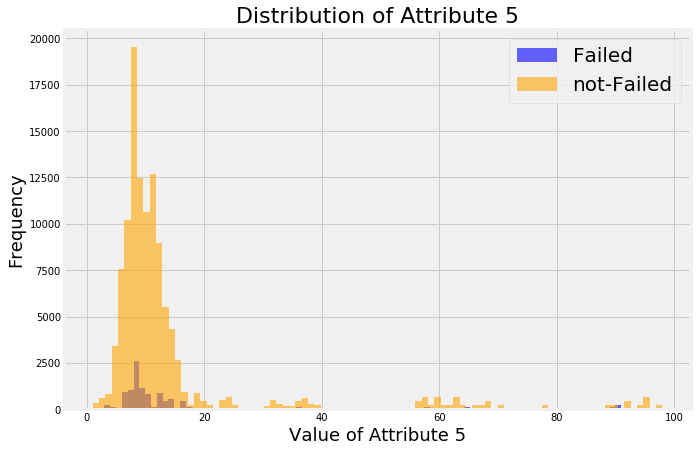

In [28]:
# Create figure.
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(df[df['device'].isin(failed_devices)]['attribute5'],
         bins=90,
         color='blue',
         alpha=0.6,
         label='Failed')

plt.hist(df[~df['device'].isin(failed_devices)]['attribute5'],
         bins=90,
         color='orange',
         alpha=0.6,
         label='not-Failed')

# Label axes.
plt.title('Distribution of Attribute 5', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Value of Attribute 5', fontsize=18)

# Create legend.
plt.legend(fontsize=20)

`attribute5` is mostly the same for each device and the standard deviations were also very small so I doubt there will be much predicting power from it.

### Telemetry progression of the failed devices

In [29]:
failed_df.sort_values(by='date', inplace=True)
failed_grid = qgrid.QGridWidget(df=failed_df, show_toolbar=True)
failed_grid

C:\Users\flake\Anaconda3\envs\ga_dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

I used qgrid to look at all how failed devices' telemetry changed over time.  There were a few patterns that showed up for a few devices but didn't hold true for others.  Overall, I got the idea of the scale of the attributes and some notion how they changed over time for each device and how they varied between devices but it did not find any strong indications of which features would be best for modeling.  